In this notebook we first plot the results of the downsampling experiement, which are supplemetnary figure 4

Then we plot network modules for Figure 3f and the cross module performances in 3g-h and supplementary figure 5

## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joypy
from shutil import copyfile

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('../scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')
sys.path.append('/home/bharris/vshape/scripts/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from rank import rank
from processify import processify
from egad import run_egad
from egad_by_gene import run_egad_gene_score

import biccn_nw_perf_funcs as perf
import load_pearson_networks
import egad_train_test_terms as egad_tt

## Functions

In [18]:
def contains_number(string):
    return re.search('\d', string)


def fix_marker_name(name):
    split_name = name.split('.')
    if name == 'Non.Neuronal':
        return name
    if len(split_name) == 1:
        return name
    if len(split_name) == 2:

        return '_'.join(split_name)
    if len(split_name) == 3:
        if contains_number(split_name[1]):
            return f'{split_name[0]}.{split_name[1]}_{split_name[2]}'
        else:
            return '_'.join(split_name)


fix_marker_name = np.vectorize(fix_marker_name)

## Load Data

In [9]:
dataset_dict = perf.dataset_dict
genes = perf.genes

In [10]:
kegg_tidy = pd.read_csv('/home/bharris/reference_networks/kegg/kegg_all.csv',
                        index_col=0)

kegg_tidy.head()

,V1,V2,V3
1,mmu00010,11674,Aldoa
2,mmu00010,11676,Aldoc
3,mmu00010,230163,Aldob
4,mmu00010,353204,Aldoart1
5,mmu00010,110695,Aldh7a1


In [11]:
kegg_tidy.set_index('V3', inplace=True)

kegg_genes = np.unique(kegg_tidy.index.values)

kegg_terms = np.unique(kegg_tidy.V1.values)

kegg = pd.DataFrame(0, index=kegg_genes, columns=kegg_terms)
for i, j in kegg_tidy[['V1']].groupby('V1').groups.items():
    kegg.at[j, i] = 1

In [12]:
nws_path = '/home/bharris/biccn_paper/data/networks/'
markers_path = '/home/bharris/biccn_paper/data/de_one_v_all/'

In [13]:
all_datasets = np.array(list(dataset_dict.keys()))

## Identify Subclasses and Clusters Needed

In [14]:
subclass_labels = {}
all_subclasses = []
cluster_labels = {}
all_clusters = []
all_joint_clusters = []
joint_clusters = {}
for dataset in dataset_dict:
    logging.info(dataset)
    andata = sc.read_h5ad(dataset_dict[dataset]['andata'])
    andata = andata[andata.obs.class_label.isin(['GABAergic',
                                                 'Glutamatergic'])]
    subclass_counts = andata.obs.subclass_label.value_counts()
    cluster_counts = andata.obs.cluster_label.value_counts()
    joint_cluster_counts = andata.obs.joint_cluster_label.value_counts()

    subclass_counts = subclass_counts[subclass_counts >= 100]
    cluster_counts = cluster_counts[cluster_counts>= 100]
    joint_cluster_counts = joint_cluster_counts[joint_cluster_counts >= 100]

    all_subclasses.extend(subclass_counts.index.values)
    all_clusters.extend(cluster_counts.index.values)
    all_joint_clusters.extend(joint_cluster_counts.index.values)

    subclass_labels[dataset] = subclass_counts.index.values
    cluster_labels[dataset] = cluster_counts.index.values
    joint_clusters[dataset] = joint_cluster_counts.index.values.astype(
        str)
    del andata
    gc.collect()
all_subclasses = np.unique(all_subclasses)
all_clusters = np.unique(all_clusters)
all_joint_clusters = np.unique(all_joint_clusters)

2020-03-05 12:11:49,853 - zeng_10x_cell
2020-03-05 12:14:09,541 - zeng_10x_nuc
2020-03-05 12:15:12,371 - zeng_smart_cell
2020-03-05 12:15:30,133 - zeng_smart_nuc
2020-03-05 12:15:45,589 - zeng_10x_cell_v3
2020-03-05 12:17:07,003 - zeng_10x_nuc_v3
2020-03-05 12:17:29,585 - macosko_10x_nuc_v3


In [15]:
subclass_spec = pd.DataFrame(0, index=all_datasets, columns=all_subclasses)
cluster_spec = pd.DataFrame(0, index=all_datasets, columns=all_clusters)
joint_spec = pd.DataFrame(0, index=all_datasets, columns=all_joint_clusters)
for dataset in subclass_labels:
    logging.info(dataset)
    subclass_spec.at[dataset, subclass_labels[dataset]] = 1
    cluster_spec.at[dataset, cluster_labels[dataset]] = 1
    joint_spec.at[dataset, joint_clusters[dataset]] = 1

2020-03-05 12:19:11,537 - zeng_10x_cell
2020-03-05 12:19:11,542 - zeng_10x_nuc
2020-03-05 12:19:11,545 - zeng_smart_cell
2020-03-05 12:19:11,548 - zeng_smart_nuc
2020-03-05 12:19:11,550 - zeng_10x_cell_v3
2020-03-05 12:19:11,553 - zeng_10x_nuc_v3
2020-03-05 12:19:11,556 - macosko_10x_nuc_v3


In [17]:
joint_spec.to_csv('/home/bharris/biccn_paper/data/networks/nearest_centroid/joint_cluster_spec_table.csv')

In [ ]:
sns.countplot(joint_spec.sum())
plt.show()

In [22]:
subclass_spec.to_csv(
    '/home/bharris/biccn_paper/data/networks/nearest_centroid/subclass_spec_table.csv'
)

In [21]:
ax = sns.countplot(cluster_spec.sum())
ax.set(yscale='log')

In [22]:
cluster_spec.to_csv(
    '/home/bharris/biccn_paper/data/networks/nearest_centroid/cluster_spec_table.csv'
)

### Load Specs 
Load Specs so you don't have to recalulate everytime

In [23]:
cluster_spec = pd.read_csv( '/home/bharris/biccn_paper/data/networks/nearest_centroid/cluster_spec_table.csv',index_col=0)
subclass_spec = pd.read_csv('/home/bharris/biccn_paper/data/networks/nearest_centroid/subclass_spec_table.csv',index_col=0)
joint_cluster_spec = pd.read_csv('/home/bharris/biccn_paper/data/networks/nearest_centroid/joint_cluster_spec_table.csv',index_col=0)


## Compute Aggregate Networks

In [24]:
for cluster in cluster_spec.columns:
    logging.info(cluster)
    datasets = cluster_spec.index[cluster_spec[cluster].astype(bool)].values
    if len(datasets) == 1:
        copyfile(
            f'{nws_path}nearest_centroid/{datasets[0]}/nearest_centroid_nw_cluster_label_{cluster}_50.hdf5',
            f'{nws_path}nearest_centroid/aggregate/nearest_centroid_nw_cluster_label_{cluster}_50.hdf5'
        )
        continue
    agg = np.zeros([genes.shape[0], genes.shape[0]])
    for dataset in datasets:
        logging.info(dataset)
        agg += pd.read_hdf(
            f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_nw_cluster_label_{cluster}_50.hdf5',
            'nw')
    pd.DataFrame(rank(agg), index=genes, columns=genes).to_hdf(
        f'{nws_path}nearest_centroid/aggregate/nearest_centroid_nw_cluster_label_{cluster}_50.hdf5',
        'nw')
    del agg
    gc.collect()

2020-03-05 09:19:53,524 - L2.3_IT
2020-03-05 09:19:53,525 - zeng_10x_nuc
2020-03-05 09:19:53,892 - zeng_smart_nuc
2020-03-05 09:19:54,274 - zeng_10x_cell_v3
2020-03-05 09:19:59,502 - L2.3_IT_1
2020-03-05 09:19:59,504 - zeng_10x_nuc_v3
2020-03-05 09:19:59,840 - macosko_10x_nuc_v3
2020-03-05 09:20:06,695 - L2.3_IT_2
2020-03-05 09:20:06,697 - zeng_10x_nuc_v3
2020-03-05 09:20:06,993 - macosko_10x_nuc_v3
2020-03-05 09:20:13,691 - L2.3_IT_3
2020-03-05 09:20:13,991 - L2.3_IT_Cdh13_Fos
2020-03-05 09:20:14,628 - L2.3_IT_Cdh13_Met
2020-03-05 09:20:15,280 - L2.3_IT_Cdh13_Sla
2020-03-05 09:20:15,282 - zeng_10x_cell
2020-03-05 09:20:15,727 - zeng_smart_cell
2020-03-05 09:20:22,642 - L2.3_IT_Macc1
2020-03-05 09:20:22,645 - zeng_10x_cell
2020-03-05 09:20:23,025 - zeng_smart_cell
2020-03-05 09:20:29,840 - L2.3_IT_S100a6
2020-03-05 09:20:30,159 - L2.3_IT_S100a6_
2020-03-05 09:20:30,664 - L5.6_NP_2
2020-03-05 09:20:31,378 - L5.6_NP_3
2020-03-05 09:20:32,108 - L5.6_NP_CT
2020-03-05 09:20:32,873 - L5_ET_1

In [25]:
for subclass in subclass_spec.columns:
    logging.info(subclass)
    datasets = subclass_spec.index[subclass_spec[subclass].astype(bool)].values
    if len(datasets) == 1:
        copyfile(
            f'{nws_path}nearest_centroid/{datasets[0]}/nearest_centroid_nw_subclass_label_{subclass}_50.hdf5',
            f'{nws_path}nearest_centroid/aggregate/nearest_centroid_nw_subclass_label_{subclass}_50.hdf5'
        )
        continue
    agg = np.zeros([genes.shape[0], genes.shape[0]])
    for dataset in datasets:
        logging.info(dataset)
        agg += pd.read_hdf(
            f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_nw_subclass_label_{subclass}_50.hdf5',
            'nw')
    pd.DataFrame(rank(agg), index=genes, columns=genes).to_hdf(
        f'{nws_path}nearest_centroid/aggregate/nearest_centroid_nw_subclass_label_{subclass}_50.hdf5',
        'nw')
    del agg
    gc.collect()

2020-03-05 09:31:16,278 - L2.3_IT
2020-03-05 09:31:16,279 - zeng_10x_cell
2020-03-05 09:31:16,863 - zeng_10x_nuc
2020-03-05 09:31:17,294 - zeng_smart_cell
2020-03-05 09:31:17,810 - zeng_smart_nuc
2020-03-05 09:31:18,229 - zeng_10x_cell_v3
2020-03-05 09:31:18,464 - zeng_10x_nuc_v3
2020-03-05 09:31:18,707 - macosko_10x_nuc_v3
2020-03-05 09:31:26,022 - L5.6_NP
2020-03-05 09:31:26,023 - zeng_10x_cell
2020-03-05 09:31:26,358 - zeng_10x_nuc
2020-03-05 09:31:26,658 - zeng_smart_cell
2020-03-05 09:31:26,973 - zeng_smart_nuc
2020-03-05 09:31:27,315 - zeng_10x_cell_v3
2020-03-05 09:31:27,584 - zeng_10x_nuc_v3
2020-03-05 09:31:27,814 - macosko_10x_nuc_v3
2020-03-05 09:31:34,699 - L5_ET
2020-03-05 09:31:34,701 - zeng_10x_cell_v3
2020-03-05 09:31:34,968 - zeng_10x_nuc_v3
2020-03-05 09:31:35,202 - macosko_10x_nuc_v3
2020-03-05 09:31:42,055 - L5_IT
2020-03-05 09:31:42,056 - zeng_10x_cell
2020-03-05 09:31:42,403 - zeng_10x_nuc
2020-03-05 09:31:42,704 - zeng_smart_cell
2020-03-05 09:31:43,024 - zeng_sm

In [26]:
for joint_cluster in joint_spec.columns:
    logging.info(joint_cluster)
    datasets = joint_spec.index[joint_spec[joint_cluster].astype(bool)].values
    if len(datasets) == 1:
        copyfile(
            f'{nws_path}nearest_centroid/{datasets[0]}/nearest_centroid_nw_joint_cluster_label_{joint_cluster}_50.hdf5',
            f'{nws_path}nearest_centroid/aggregate/nearest_centroid_nw_joint_cluster_label_{joint_cluster}_50.hdf5'
        )
        continue
    agg = np.zeros([genes.shape[0], genes.shape[0]])
    for dataset in datasets:
        logging.info(dataset)
        agg += pd.read_hdf(
            f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_nw_joint_cluster_label_{joint_cluster}_50.hdf5',
            'nw')
    pd.DataFrame(rank(agg), index=genes, columns=genes).to_hdf(
        f'{nws_path}nearest_centroid/aggregate/nearest_centroid_nw_joint_cluster_label_{joint_cluster}_50.hdf5',
        'nw')
    del agg
    gc.collect()

NameError: name 'joint_spec' is not defined

## Aggregate By Dataset

In [ ]:
for dataset in dataset_dict:
    logging.info(dataset )
    subclasses = subclass_spec.columns[subclass_spec.loc[dataset].astype(bool)].values
    joint_clusters = joint_cluster_spec.columns[joint_cluster_spec.loc[dataset].astype(bool)].values
    clusters = cluster_spec.columns[cluster_spec.loc[dataset].astype(bool)].values
    for level, names in zip(['class_label','subclass_label','cluster_label','joint_cluster_label'],
                            [['GABAergic','Glutamatergic'],subclasses,clusters,joint_clusters]):
        logging.info(level)
        agg_nw = np.zeros([genes.shape[0],genes.shape[0]])
        for name in names:
            logging.info(name)
            try:
                nw=pd.read_hdf(f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_nw_{level}_{name}_50.hdf5','nw')
            except:
                logging.info(f'NW {dataset} {level} {name} does not exist')
                continue
            agg_nw+=nw.values
            del nw
            gc.collect()
        ds_agg = pd.DataFrame(rank(agg_nw),index=genes,columns=genes)
        ds_agg.to_hdf(f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_agg_nw_{level}_50.hdf5','nw')
        del ds_agg
        gc.collect()

In [ ]:
for level in ['class_label','subclass_label','cluster_label','joint_cluster_label']:
    logging.info(level)
    agg_nw = np.zeros([genes.shape[0],genes.shape[0]])
    for dataset in dataset_dict:
        logging.info(dataset)
        nw= pd.read_hdf(f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_agg_nw_{level}_50.hdf5','nw')
        agg_nw+=nw.values
        del nw
        gc.collect()
    lvl_agg = pd.DataFrame(rank(agg_nw), index=genes,columns=genes)
    lvl_agg.to_hdf(f'{nws_path}nearest_centroid/aggregate/nearest_centroid_agg_nw_{level}_50.hdf5','nw')
    del lvl_agg
    gc.collect()

## Downsample Datasets (Supplementary Figure 4)

In [14]:
stephan_markers =pd.read_csv('/home/bharris/biccn_paper/data/stephan_marker_nw.csv',index_col=0)

In [87]:
nearest_networks = {}
for level in ['class_label','subclass_label','joint_cluster_label']:
    level_networks = {}
    logging.info(level)
    for dataset in np.concatenate([all_datasets,['aggregate']]):
        nw = pd.read_hdf(f'{nws_path}nearest_centroid/{dataset}/nearest_centroid_agg_nw_{level}_50.hdf5','nw')
        level_networks[dataset] = nw
        del nw
        gc.collect()
        
    nearest_networks[level] = level_networks
    del level_networks
    gc.collect()

2020-03-06 09:09:36,833 - class_label
2020-03-06 09:09:39,008 - subclass_label
2020-03-06 09:09:41,125 - joint_cluster_label


In [88]:
nw_combinations = list(combinations(all_datasets, 4))
all_results = []
for nw_ds in nw_combinations:
    
    marker_ds = all_datasets[~np.in1d(all_datasets, nw_ds)]
    markers_name = '_'.join(marker_ds)
    logging.info(markers_name)
    markers_nw = pd.read_csv(f'/home/bharris/biccn_paper/data/markers_3ds/markers_{markers_name}.csv',
                             index_col=0)
    iteration_name = '_'.join(nw_ds)
    for meta_level in [
            'class_label', 'subclass_label', 'joint_cluster_label',
    ]:
        agg_nw = perf.combine_networks(nw_ds, meta_level, nearest_networks)
        egad_res = perf.add_attributes(run_egad(markers_nw, agg_nw),
                                       meta_level, iteration_name)

        all_results.append(
            pd.melt(egad_res.reset_index(),
                    id_vars=['labels', 'metric', 'name'],
                    var_name='EGAD_res'))
        del agg_nw

        del egad_res
        gc.collect()
    del markers_nw
    gc.collect()

2020-03-06 09:10:01,651 - zeng_10x_cell_v3_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-06 09:10:22,446 - zeng_smart_nuc_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-06 09:10:43,200 - zeng_smart_nuc_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-03-06 09:11:04,395 - zeng_smart_nuc_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-03-06 09:11:24,871 - zeng_smart_cell_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-06 09:11:46,575 - zeng_smart_cell_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-03-06 09:12:07,349 - zeng_smart_cell_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-03-06 09:12:30,179 - zeng_smart_cell_zeng_smart_nuc_macosko_10x_nuc_v3
2020-03-06 09:12:51,622 - zeng_smart_cell_zeng_smart_nuc_zeng_10x_nuc_v3
2020-03-06 09:13:13,326 - zeng_smart_cell_zeng_smart_nuc_zeng_10x_cell_v3
2020-03-06 09:13:35,371 - zeng_10x_nuc_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-06 09:13:57,788 - zeng_10x_nuc_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-03-06 09:14:19,990 - zeng_10x_nuc_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-03-06 09:14:42,0

In [89]:
nearest_centroid_results= pd.concat(all_results)

In [15]:
pearson_networks = load_pearson_networks.load_all_networks()

2020-03-18 14:25:12,990 - zeng_10x_cell
2020-03-18 14:25:31,466 - zeng_10x_nuc
2020-03-18 14:25:50,656 - zeng_smart_cell
2020-03-18 14:26:09,743 - zeng_smart_nuc
2020-03-18 14:26:28,958 - zeng_10x_cell_v3
2020-03-18 14:26:47,963 - zeng_10x_nuc_v3
2020-03-18 14:27:06,934 - macosko_10x_nuc_v3


In [44]:
nw_combinations = list(combinations(all_datasets, 4))
all_results = []
for nw_ds in nw_combinations:
    
    marker_ds = all_datasets[~np.in1d(all_datasets, nw_ds)]
    markers_name = '_'.join(marker_ds)
    logging.info(markers_name)
    markers_nw = pd.read_csv(f'/home/bharris/biccn_paper/data/markers_3ds/markers_{markers_name}.csv',
                             index_col=0)
    iteration_name = '_'.join(nw_ds)
    for meta_level in [
            'class_label', 'subclass_label', 'joint_cluster_label',
    ]:
        agg_nw = perf.combine_networks(nw_ds, meta_level, pearson_networks)
        egad_res = perf.add_attributes(run_egad(markers_nw, agg_nw),
                                       meta_level, iteration_name)

        all_results.append(
            pd.melt(egad_res.reset_index(),
                    id_vars=['labels', 'metric', 'name'],
                    var_name='EGAD_res'))
        del agg_nw

        del egad_res
        gc.collect()
    del markers_nw
    gc.collect()

2020-03-05 13:46:49,917 - zeng_10x_cell_v3_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-05 13:47:08,834 - zeng_smart_nuc_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-05 13:47:28,012 - zeng_smart_nuc_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-03-05 13:47:47,153 - zeng_smart_nuc_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-03-05 13:48:05,885 - zeng_smart_cell_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-05 13:48:24,972 - zeng_smart_cell_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-03-05 13:48:44,133 - zeng_smart_cell_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-03-05 13:49:03,098 - zeng_smart_cell_zeng_smart_nuc_macosko_10x_nuc_v3
2020-03-05 13:49:21,911 - zeng_smart_cell_zeng_smart_nuc_zeng_10x_nuc_v3
2020-03-05 13:49:40,704 - zeng_smart_cell_zeng_smart_nuc_zeng_10x_cell_v3
2020-03-05 13:49:59,557 - zeng_10x_nuc_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-03-05 13:50:18,449 - zeng_10x_nuc_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-03-05 13:50:37,342 - zeng_10x_nuc_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-03-05 13:50:56,3

In [55]:
full_network_results = pd.concat(all_results)

In [90]:
nearest_centroids_avg_aurocs = nearest_centroid_results[nearest_centroid_results.EGAD_res =='AUC'] \
    .groupby(['labels','metric']) \
    .mean() \
    .reset_index()
nearest_centroids_avg_aurocs.rename(columns={'value':'nearest_centroid'}, inplace=True)

In [56]:
full_network_avg_aurocs = full_network_results[full_network_results.EGAD_res =='AUC'] \
    .groupby(['labels','metric']) \
    .mean() \
    .reset_index()
full_network_avg_aurocs.rename(columns={'value':'full_dataset'}, inplace=True)

In [91]:
combined_avg_auroc = pd.concat([full_network_avg_aurocs,nearest_centroids_avg_aurocs],axis=1)

combined_avg_auroc = combined_avg_auroc.loc[:,~combined_avg_auroc.columns.duplicated()]    

combined_avg_auroc = combined_avg_auroc[combined_avg_auroc.labels!='Non.Neuronal']

In [25]:
all_metadata_color = pd.read_csv(
    '/home/bharris/biccn_paper/data/biccn_mouse_full_labels_new.csv',
    index_col=0)
class_label_palette = all_metadata_color[[
    'class_label', 'class_color'
]].groupby(['class_label', 'class_color']).size().reset_index().sort_values(
    ['class_label', 0], ascending=False).drop_duplicates(
        subset='class_label').set_index('class_label')['class_color']
replace_hyphen = np.vectorize(lambda x: x.replace('-', '.'))
class_label_palette.index = replace_hyphen(class_label_palette.index)

subclass_colors = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_colors.csv', index_col=1,header=None)[0]
replace_space = np.vectorize(lambda x: x.replace(' ', '.'))
replace_slash = np.vectorize(lambda x: x.replace('/', '.'))
subclass_colors.index = fix_marker_name(replace_slash(replace_space(subclass_colors.index)))


combined_color_pal = pd.concat([subclass_colors,class_label_palette])

In [93]:
colormap = sns.color_palette(combined_color_pal[combined_avg_auroc.labels.unique()].values,desat=.5)
colormap_dict =dict(zip(combined_avg_auroc.labels.unique(),colormap))

In [121]:
combined_avg_auroc[combined_avg_auroc.labels.isin(subclass_colors.index)].groupby('metric').mean()

,full_dataset,nearest_centroid
metric,,
class_label,0.927940,0.830232
joint_cluster_label,0.821948,0.821828
subclass_label,0.845145,0.813759


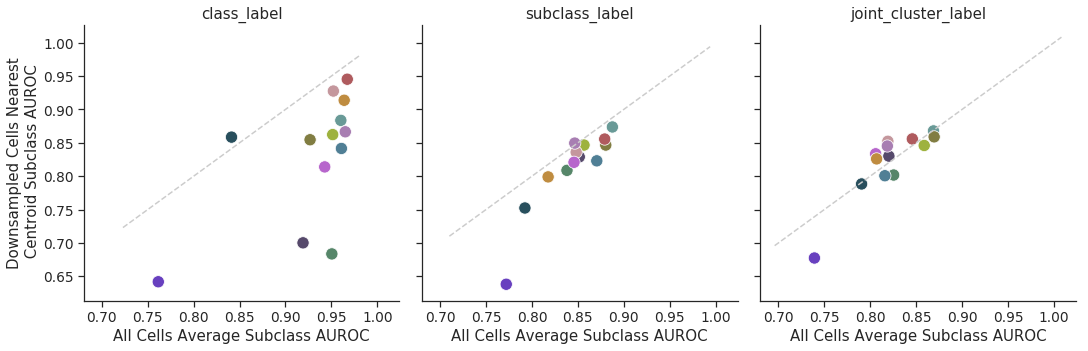

In [104]:
g = sns.relplot(data=combined_avg_auroc[combined_avg_auroc.labels.isin(subclass_colors.index)],
                x='full_dataset',
                y='nearest_centroid',
                hue='labels',
                col='metric',
                palette=colormap_dict,
                col_order=['class_label','subclass_label','joint_cluster_label'],
                s=150,
                legend=None)
g.set_titles("{col_name}")
g.set_xlabels('All Cells Average Subclass AUROC')
g.set_ylabels('Downsampled Cells Nearest\n Centroid Subclass AUROC')
for ax in g.axes[0]: 
    ax.plot(ax.get_xlim(),ax.get_xlim(),c='.8',ls='--')
plt.savefig('/home/bharris/biccn_paper/figures/nearest_centroid_results.pdf',
            transparent=True)

Correlations between full networks and Centroids : 
* Class label : .58
* Subclass label: .90
* Joint Cluster Label : .87


In [57]:
joy_data = full_network_results[(full_network_results.EGAD_res=='AUC') & 
                                          (full_network_results.labels.isin(subclass_colors.index.drop('L5_ET')))].groupby(['labels','metric']).mean().reset_index()

In [58]:
def code_labels(l):
    if l is 'class_label':
        return 'a'
    elif l is 'subclass_label':
        return 'b'
    elif l  is 'joint_cluster_label':
        return 'c'
    else:
        return 'd'
code_labels = np.vectorize(code_labels)
joy_data['metric_code'] = code_labels(joy_data.metric.values)

##  Figure 3e

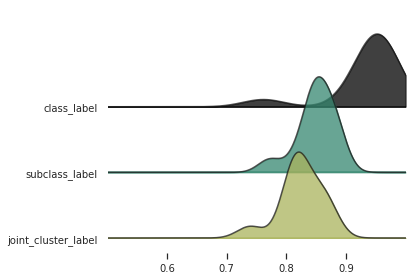

In [435]:
joypy.joyplot(joy_data, by='metric_code', labels=['class_label','subclass_label','joint_cluster_label'], 
              colormap=plt.cm.gist_earth, alpha=.75, x_range=[.5,1])
plt.savefig('/home/bharris/biccn_paper/figures/multiscale_joyplot.pdf',transparent=True)

## Compare Subclass Connectivity (Figures 3fgh and Supp 5)


In [19]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [20]:
def plot_two_modules(module1, module2, nw, threshold=.99,pos=None, legend=False, ax=None):
    m1_genes = genes[stephan_markers[module1].astype(bool)]
    if type(module2) is np.ndarray:
        m2_genes = module2
        module2 = 'random'
    else:
        m2_genes = genes[stephan_markers[module2].astype(bool)]
    
    shared_genes = np.intersect1d(m1_genes, m2_genes)
    both_genes = np.unique(np.concatenate([m1_genes,m2_genes]))
    adj_all = nw.loc[both_genes, both_genes]>threshold
    new_idx = adj_all.index[adj_all.sum()- np.diag(adj_all)!=0]
    adj =adj_all.loc[new_idx, new_idx]
    
    m1_genes = np.intersect1d(m1_genes, new_idx)
    m2_genes = np.intersect1d(m2_genes, new_idx)
    shared_genes = np.intersect1d(shared_genes, new_idx)
    both_genes = np.intersect1d(both_genes, new_idx)

    G= nx.from_pandas_adjacency(adj)
    G.remove_nodes_from(list(nx.isolates(G)))
    if ax is None:
        fig, ax = plt.subplots()
    
    if pos is None:
        pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=m1_genes,
                           node_color=lighten_color(subclass_colors[module1],.5),
                           ax=ax,
                           alpha=.9)
    m2_color = 'g' if module2 == 'random' else lighten_color(subclass_colors[module2],.5)
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=m2_genes, 
                           node_color=m2_color,
                           ax=ax,
                           alpha=.5)
    nx.draw_networkx_nodes(G,pos,nodelist=shared_genes, node_color='.4',ax=ax, alpha=.5)
    nx.draw_networkx_edges(G,pos,ax=ax)
    ax.axis('off')
    patches = [mpatches.Patch(color='.4',label='Shared'),
               mpatches.Patch(color=lighten_color(subclass_colors[module1],.5), label=module1),
               mpatches.Patch(color=m2_color, label=module2)
              ]

    if legend:
        ax.legend(handles=patches, loc=(.9,.8),frameon=False)
    return adj_all,ax,pos

In [21]:
stephan_markers.columns = fix_marker_name(stephan_markers.columns)

In [ ]:
rand_module = np.random.choice(genes,size=100)

_,ax,pos = plot_two_modules('Sst','Vip',pearson_networks['class_label']['aggregate'], threshold=.99, legend=True)
ax.set(title='Sst + Vip Class Label')
#plt.savefig('/home/bharris/biccn_paper/figures/aggregate_class_label_Sst_Vip.pdf',transparent=True)

_,ax,_ = plot_two_modules('Sst','Vip',pearson_networks['subclass_label']['aggregate'], threshold=.99)
ax.set(title='Sst + Vip Subclass Label')
#plt.savefig('/home/bharris/biccn_paper/figures/aggregate_subclass_label_Sst_Vip.pdf',transparent=True)

_,ax,_ = plot_two_modules('Sst','Vip',pearson_networks['joint_cluster_label']['aggregate'], threshold=.99)
ax.set(title='Sst + Vip Cluster Label')
#plt.savefig('/home/bharris/biccn_paper/figures/aggregate_joint_cluster_label_Sst_Vip.pdf',transparent=True)
plt.show()

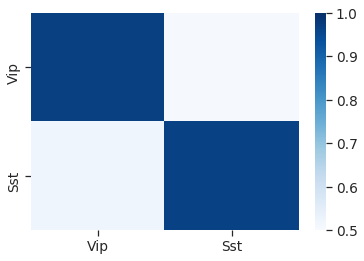

In [82]:
tt_vip_sst_class_label = egad_tt.run_egad_train_test(stephan_markers[['Vip','Sst']],
                                        pearson_networks['class_label']['aggregate'])
np.fill_diagonal(tt_vip_sst_class_label.values,run_egad(stephan_markers[['Vip','Sst']],
                                                 pearson_networks['class_label']['aggregate']).AUC.values)
sns.heatmap(tt_vip_sst_class_label,cmap='Blues',vmin=.5, vmax=1)
plt.savefig('/home/bharris/biccn_paper/figures/figure3_tt_class_label.pdf',transparent=True)

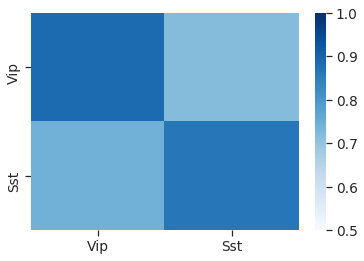

In [83]:
tt_vip_sst_subclass_label = egad_tt.run_egad_train_test(stephan_markers[['Vip','Sst']],
                                        pearson_networks['subclass_label']['aggregate'])
np.fill_diagonal(tt_vip_sst_subclass_label.values,run_egad(stephan_markers[['Vip','Sst']],
                                                 pearson_networks['subclass_label']['aggregate']).AUC.values)
sns.heatmap(tt_vip_sst_subclass_label,cmap='Blues',vmin=.5, vmax=1)
plt.savefig('/home/bharris/biccn_paper/figures/figure3_tt_subclass_label.pdf',transparent=True)

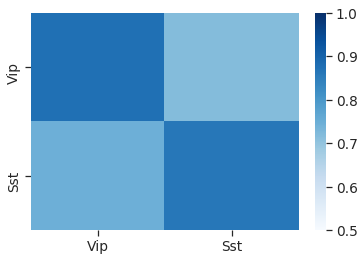

In [84]:
tt_vip_sst_cluster_label = egad_tt.run_egad_train_test(stephan_markers[['Vip','Sst']],
                                        pearson_networks['joint_cluster_label']['aggregate'])
np.fill_diagonal(tt_vip_sst_cluster_label.values,run_egad(stephan_markers[['Vip','Sst']],
                                                 pearson_networks['joint_cluster_label']['aggregate']).AUC.values)
sns.heatmap(tt_vip_sst_cluster_label,cmap='Blues',vmin=.5, vmax=1)
plt.savefig('/home/bharris/biccn_paper/figures/figure3_tt_cluster_label.pdf',transparent=True)

In [22]:
def get_non_diagonal_performances(nw, name, drop_row, drop_col=None):
    if drop_col is None:
        drop_col = drop_row
    temp = nw.drop(index=drop_row,columns=drop_col)
    np.fill_diagonal(temp.values,np.nan)
    temp = pd.melt(temp).dropna()[['value']]
    temp['Network'] = name
    return temp.reset_index(drop=True)

In [23]:
marker_genes = genes[(stephan_markers.drop(columns=['GABAergic','Glutamatergic','Non.Neuronal']).sum(axis=1)>0)]
not_marker_genes = genes[~(stephan_markers.drop(columns=['GABAergic','Glutamatergic','Non.Neuronal']).sum(axis=1)>0)]

In [26]:
n_rand = 200
rand_modules = pd.DataFrame(0.0, index=genes, columns = np.arange(n_rand))
for col in rand_modules.columns:
    selected = np.random.choice(genes,size=100, replace=False)
    rand_modules.at[selected,col] = 1
subclasses_tested= np.intersect1d(subclass_colors.index,stephan_markers.columns)
for subclass in subclasses_tested:
    rand_modules[subclass] = stephan_markers[subclass]

In [28]:
rand_class_label = egad_tt.run_egad_train_test(rand_modules, pearson_networks['class_label']['aggregate'])
rand_subclass_label = egad_tt.run_egad_train_test(rand_modules, pearson_networks['subclass_label']['aggregate'])
rand_cluster_label = egad_tt.run_egad_train_test(rand_modules, pearson_networks['joint_cluster_label']['aggregate'])

In [29]:
rand_perf = pd.concat([get_non_diagonal_performances(rand_class_label,'Class Label',subclasses_tested),
 get_non_diagonal_performances(rand_subclass_label,'Subclass Label',subclasses_tested),
 get_non_diagonal_performances(rand_cluster_label,'Cluster Label',subclasses_tested)])

rand_perf = pd.pivot(rand_perf.reset_index(),index='index',columns='Network')['value']

In [30]:
mixed_perf = pd.concat([get_non_diagonal_performances(rand_class_label,'Class Label',subclasses_tested, drop_col=np.arange(200)),
 get_non_diagonal_performances(rand_subclass_label,'Subclass Label',subclasses_tested, drop_col=np.arange(200)),
 get_non_diagonal_performances(rand_cluster_label,'Cluster Label',subclasses_tested, drop_col=np.arange(200))])

mixed_perf = pd.pivot(mixed_perf.reset_index(),index='index',columns='Network')['value']

In [31]:
marker_perf = pd.concat([get_non_diagonal_performances(rand_class_label,'Class Label',np.arange(200)),
 get_non_diagonal_performances(rand_subclass_label,'Subclass Label',np.arange(200)),
 get_non_diagonal_performances(rand_cluster_label,'Cluster Label',np.arange(200))])

marker_perf = pd.pivot(marker_perf.reset_index(),index='index',columns='Network')['value']

In [32]:
gist_earth = sns.color_palette('gist_earth',3)
gist_earth[0] = 'k'

In [33]:
def create_term_nw(term_vector, nw, color, threshold=.9,ax=None, remove_isolates=False):
    selected_term_genes = np.intersect1d(genes,term_vector.index[term_vector.astype(bool)])
    adj = nw.loc[selected_term_genes,selected_term_genes]>=threshold
    np.fill_diagonal(adj.values,0)
    #adj = adj.loc[adj.sum()>1,adj.sum()>1]
    if ax is None:
        fix,  ax = plt.subplots()
    G  = nx.from_pandas_adjacency(adj)
    if remove_isolates:
        G.remove_nodes_from(list(nx.isolates(G)))

    nx.draw_spring(G,node_color=color,ax=ax, node_size=5)

In [34]:
def plot_avg_perf(ax):
    avg_perf = joy_data.groupby(['metric']).mean()['value']
    ax.axvline(avg_perf['class_label'],ls='--',c=gist_earth[0], ymax=.5)
    ax.axvline(avg_perf['subclass_label'],ls='--',c=gist_earth[1], ymax=.5)
    ax.axvline(avg_perf['joint_cluster_label'],ls='--',c=gist_earth[2], ymax=.5)

In [35]:
marker_perf.mean()

Network
Class Label       0.491543
Cluster Label     0.662317
Subclass Label    0.648988
dtype: float64

In [36]:
mixed_perf.mean()

Network
Class Label       0.482437
Cluster Label     0.486972
Subclass Label    0.486110
dtype: float64

2020-03-18 12:16:05,768 - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-03-18 12:16:05,855 - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-03-18 12:16:05,969 - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-03-18 12:16:06,058 - 'c' argument looks like a single numeric RGB or

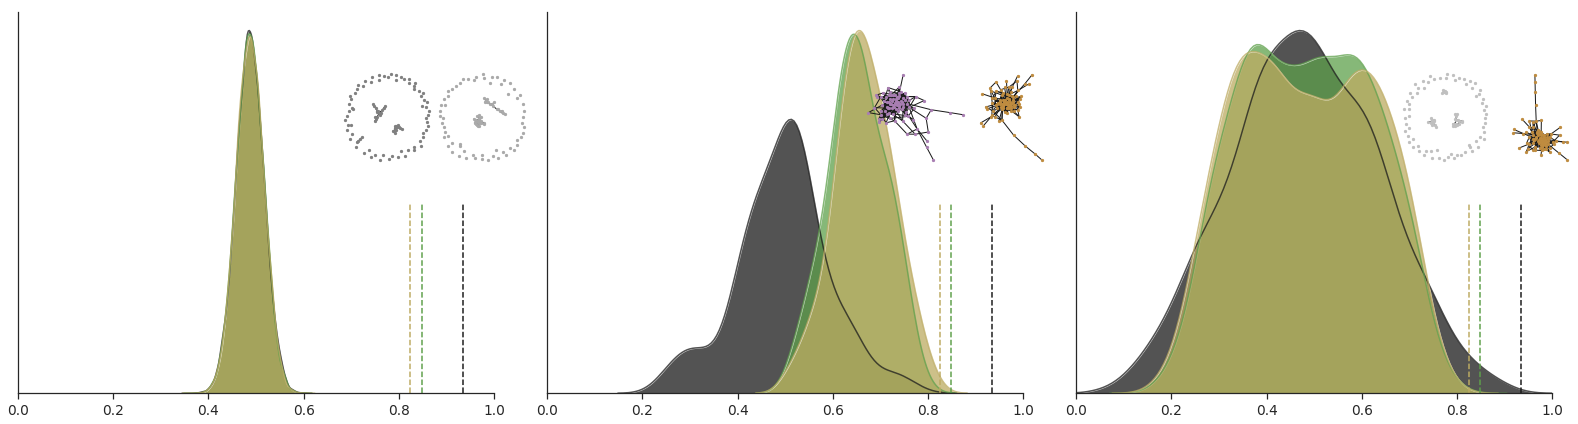

In [448]:
fig, ax = plt.subplots(figsize=(22,6), 
                       ncols=3,)
sns.kdeplot(rand_perf['Class Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[0],
            ax=ax[0])
sns.kdeplot(rand_perf['Subclass Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[1],
            ax=ax[0])
sns.kdeplot(rand_perf['Cluster Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[2],
            ax=ax[0])
axins0a = ax[0].inset_axes([.65,.6,.25,.25])
axins0a.set(aspect='equal')
create_term_nw(rand_modules[1], 
               pearson_networks['subclass_label']['aggregate'],
               sns.color_palette('gist_gray',1)[0], 
               threshold=.99,
              ax=axins0a)

axins0b = ax[0].inset_axes([.85,.6,.25,.25])
axins0b.set(aspect='equal')
create_term_nw(rand_modules[2], 
               pearson_networks['subclass_label']['aggregate'],
               sns.color_palette('gist_gray',2)[1], 
               threshold=.99,
              ax=axins0b)


sns.kdeplot(marker_perf['Class Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[0],
            ax=ax[1])
sns.kdeplot(marker_perf['Subclass Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[1],
            ax=ax[1])
sns.kdeplot(marker_perf['Cluster Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[2],
            ax=ax[1])

axins1a = ax[1].inset_axes([.65,.6,.25,.25])
axins1a.set(aspect='equal')
create_term_nw(stephan_markers['Vip'], 
               pearson_networks['subclass_label']['aggregate'],
               sns.desaturate(subclass_colors['Vip'],.5), 
               threshold=.99,
              ax=axins1a,
              remove_isolates=True)

axins1b = ax[1].inset_axes([.85,.6,.25,.25])
axins1b.set(aspect='equal')
create_term_nw(stephan_markers['Sst'], 
               pearson_networks['subclass_label']['aggregate'],
               sns.desaturate(subclass_colors['Sst'],.5), 
               threshold=.99,
              ax=axins1b,
              remove_isolates=True)

sns.kdeplot(mixed_perf['Class Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[0],
            ax=ax[2])
sns.kdeplot(mixed_perf['Subclass Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[1],
            ax=ax[2])
sns.kdeplot(mixed_perf['Cluster Label'],
            shade=True,
            alpha=.75,
            color=gist_earth[2],
            ax=ax[2])
axins2a = ax[2].inset_axes([.65,.6,.25,.25])
axins2a.set(aspect='equal')
create_term_nw(rand_modules[4], 
               pearson_networks['subclass_label']['aggregate'],
               sns.color_palette('gist_gray',3)[2], 
               threshold=.99,
              ax=axins2a)

axins2b = ax[2].inset_axes([.85,.6,.25,.25])
axins2b.set(aspect='equal')
create_term_nw(stephan_markers['Sst'], 
               pearson_networks['subclass_label']['aggregate'],
               sns.desaturate(subclass_colors['Sst'],.5), 
               threshold=.99,
              ax=axins2b,
              remove_isolates=True)

ax[0].legend().set_visible(False)
ax[0].set(yticks=[], xlim=[0,1])
ax[1].legend().set_visible(False)
ax[1].set(yticks=[],xlim=[0,1])
ax[2].legend().set_visible(False)
ax[2].set(yticks=[],xlim=[0,1])
plot_avg_perf(ax[0])
plot_avg_perf(ax[1])
plot_avg_perf(ax[2])
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/figure3_train_test.pdf',transparent=True)

In [46]:
module_marker_perc = rand_modules.loc[marker_genes,np.arange(200)].sum()/100

In [54]:
rand_marker_perf = pd.concat([rand_class_label.loc[np.arange(200), subclass_colors.index].dropna(axis=1).mean(axis=1),
          rand_subclass_label.loc[np.arange(200), subclass_colors.index].dropna(axis=1).mean(axis=1),
          rand_cluster_label.loc[np.arange(200), subclass_colors.index].dropna(axis=1).mean(axis=1)],axis=1)
rand_marker_perf.columns = ['Class Label','Subclass Label','Cluster Label']
rand_marker_perf['Percent Marker Genes'] = module_marker_perc
rand_marker_perf = pd.melt(rand_marker_perf,id_vars='Percent Marker Genes')

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


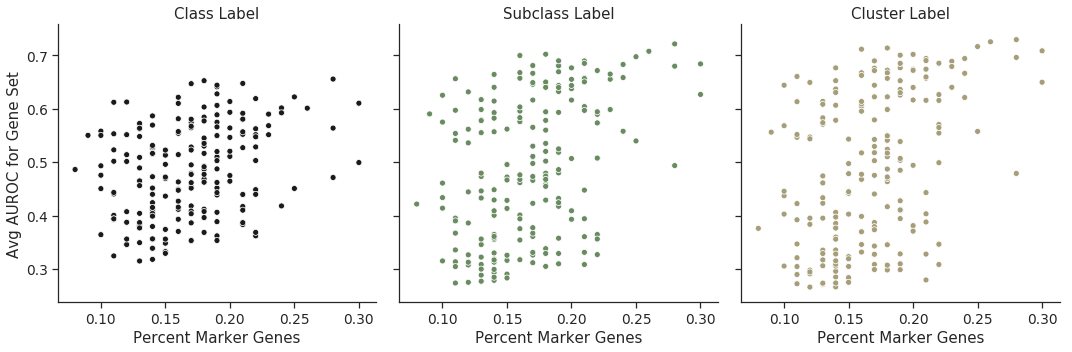

In [74]:
g = sns.relplot(data=rand_marker_perf,
                x='Percent Marker Genes',
                y='value',col='variable',
                hue='variable',
                palette=gist_earth, 
                legend=False)
g.set(ylabel='Avg AUROC for Gene Set')
g.set_titles('{col_name}')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/supp5_marker_genes_perf.pdf',
            transparent=True)

In [65]:
rand_marker_perf.groupby('variable').apply(lambda x: stats.pearsonr(x['Percent Marker Genes'].values,
                                                                    x['value'].values))

variable
Class Label        (0.3199982777452787, 3.853479413160941e-06)
Cluster Label     (0.41985343739588343, 6.062973786164864e-10)
Subclass Label    (0.4043650989988945, 2.8797904367202387e-09)
dtype: object